In [4]:
import os
import torch
import argparse
import warnings
import numpy as np
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
from src.graph_func import graph_construction
from src.utils_func import mk_dir, adata_preprocess, load_visium_sge
from src.SEDR_train import SEDR_Train


# Visualizing the Data

The processed data is a matrix for each cell, with the corresponding pca_n_comps principal components

In [5]:
def load_adata(data_name, n_clusters=20, pca_n_comps=200):
    data_root = './data/10x_Genomics_Visium/'
    # data_name = 'Visium_FFPE_Mouse_Brain'
    save_fold = os.path.join('./output/10x_Genomics_Visium/', data_name)
    # ################## Load data
    adata_h5 = load_visium_sge(sample_id=data_name, save_path=data_root)
    adata_h5.var_names_make_unique()
    adata_X = adata_preprocess(adata_h5, min_cells=5, pca_n_comps=pca_n_comps)
    return adata_h5, adata_X



In [6]:
def plot_spatial(adata_h5, data_name):
    fig, ax = plt.subplots(nrows=1, ncols=2)

    # get high resolution image
    ax[0].imshow(adata_h5.uns['spatial'][data_name]['images']['hires'], origin='lower')

    # get the spatial information
    hires_scalef = adata_h5.uns['spatial'][data_name]['scalefactors']['tissue_hires_scalef']
    spatial_x = adata_h5.obsm['spatial'][:,0] * hires_scalef
    spatial_y = adata_h5.obsm['spatial'][:,1] * hires_scalef


    ax[1].scatter(spatial_x, spatial_y, s=1)
    ax[1].set_xlim(0, max(spatial_x)*1.2)
    ax[1].set_ylim(0, max(spatial_y)*1.2)
    plt.title(data_name)
    plt.show()
    
def plot_cell2gene(adata_h5, data_name):
    cell_to_gene_matrix = sc.pp.normalize_total(adata_h5, target_sum=1, exclude_highly_expressed=True, inplace=False)['X']
    plt.figure(figsize=(80,8), dpi=100)
    plt.spy(cell_to_gene_matrix, markersize=0.01)
    plt.title(data_name)
    plt.show()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


adata: (4247, 36601)
===== Preprocessing Data 
Anndata AnnData object with n_obs × n_vars = 4247 × 16716
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'
dataset:  V1_Human_Heart
size: (4247, 16716)
number of genes 16716


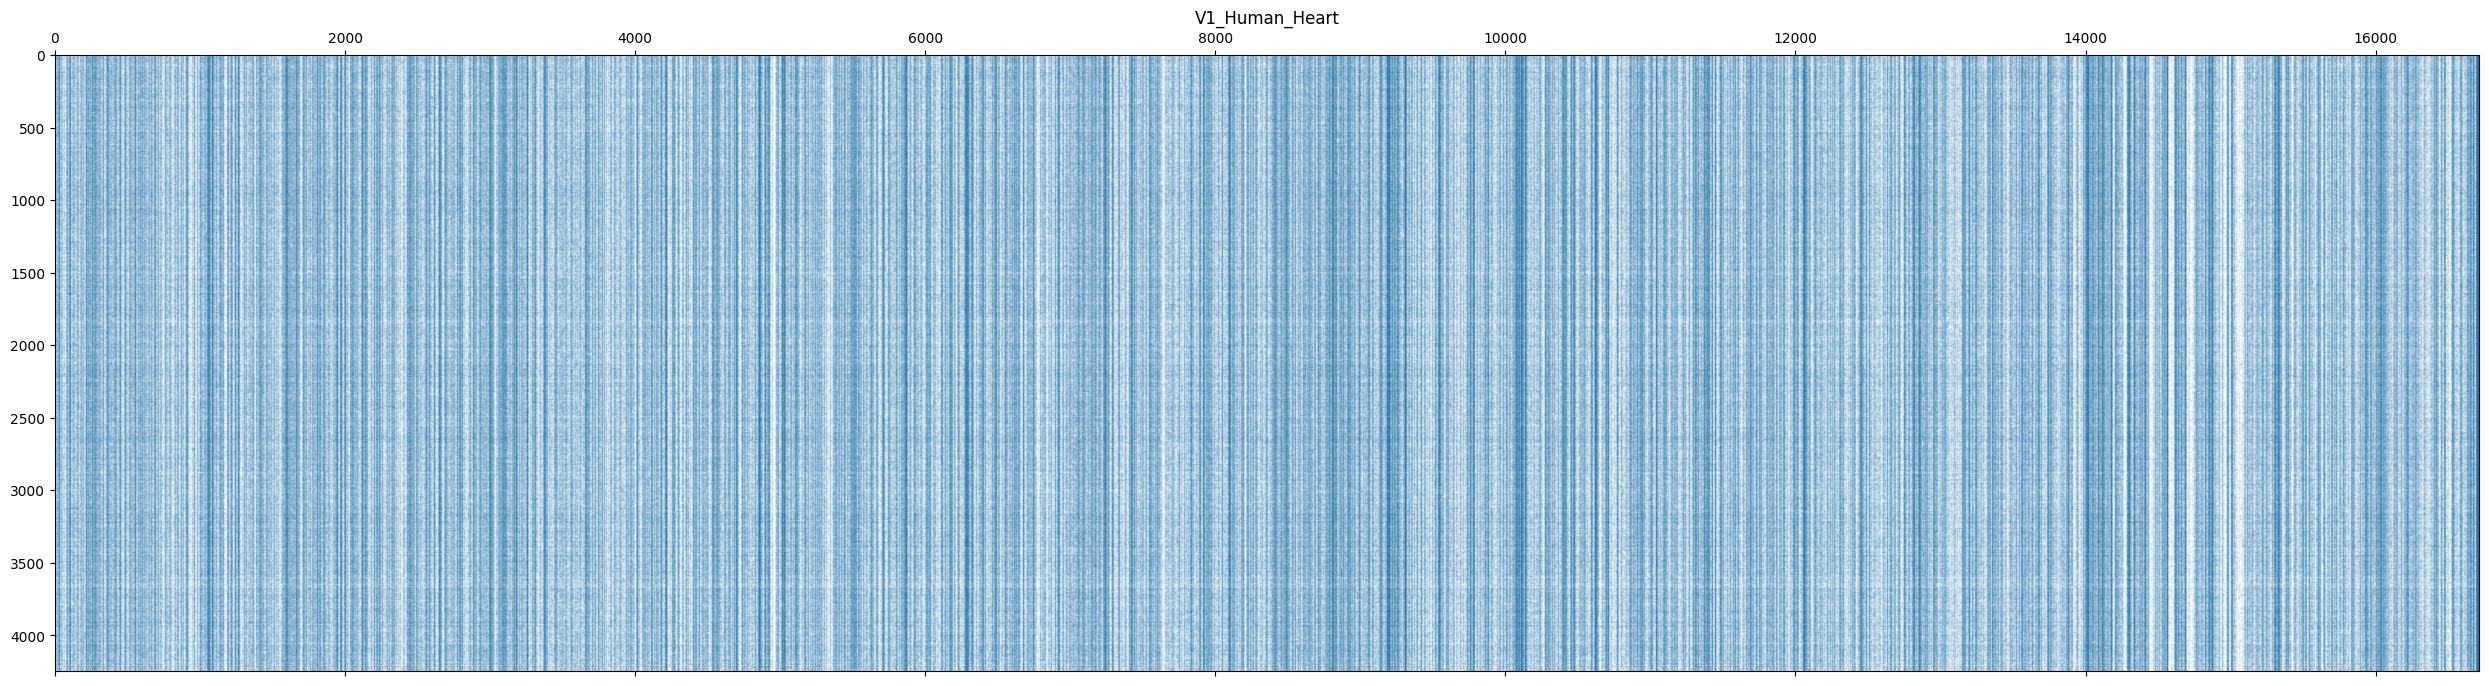

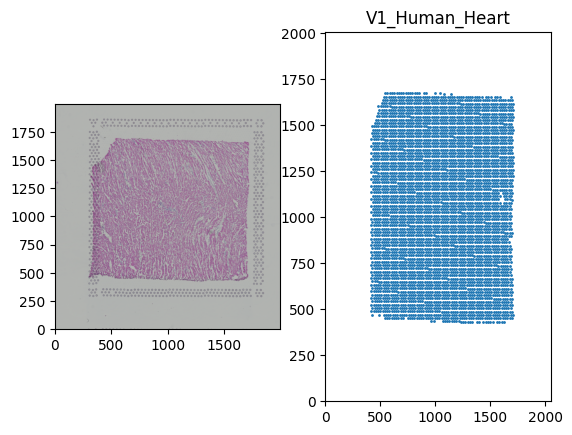

In [7]:
# datasets = ['V1_Human_Heart', 'V1_Human_Lymph_Node', \
#             'V1_Breast_Cancer_Block_A_Section_1', \
#             'Targeted_Visium_Human_BreastCancer_Immunology']

datasets = ['V1_Human_Heart']

for name in datasets:
    
    # blockPrint()
    adata_h5, adata_X = load_adata(name)
    genes = set(adata_h5.var['gene_ids'])
    # enablePrint()

    print("Anndata", adata_h5)
    
    print('dataset: ', name)
    print('size:', adata_h5.shape)
    print('number of genes', len(genes))
    plot_cell2gene(adata_h5, name)
    plot_spatial(adata_h5, name)
    
    


# Parameter Setting

In [13]:
sc.settings.figdir = './output/figures/'
sc.settings.writedir = './output/write/'
sc.settings.cachedir = './output/cache/'
sc.settings.datasetdir = './output/data/'

warnings.filterwarnings('ignore')
torch.cuda.cudnn_enabled = False
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('===== Using device: ' + device + " =====")

argsDict = {
    'k': 10,
    'knn_distanceType': 'euclidean',
    'epochs': 200,
    'cell_feat_dim': 200, 
    'feat_hidden1': 100,
    'feat_hidden2': 20,
    'gcn_hidden1': 32,
    'gcn_hidden2': 8,
    'p_drop': 0.2,
    'using_dec': True,
    'using_mask': False,
    'feat_w': 10,
    'gcn_w': 0.1,
    'dec_kl_w': 10,
    'gcn_lr': 0.01,
    'gcn_decay': 0.01,
    'dec_cluster_n': 10,
    'dec_interval': 20,
    'dec_tol': 0.00,
    'eval_resolution': 1,
    'eval_graph_n': 20,
    'device': device
}
params = argparse.Namespace(**argsDict)
params

===== Using device: cpu =====


Namespace(cell_feat_dim=200, dec_cluster_n=10, dec_interval=20, dec_kl_w=10, dec_tol=0.0, device='cpu', epochs=200, eval_graph_n=20, eval_resolution=1, feat_hidden1=100, feat_hidden2=20, feat_w=10, gcn_decay=0.01, gcn_hidden1=32, gcn_hidden2=8, gcn_lr=0.01, gcn_w=0.1, k=10, knn_distanceType='euclidean', p_drop=0.2, using_dec=True, using_mask=False)

In [14]:
# Visium Spatial Gene Expression data from 10x Genomics.
# Database: https://support.10xgenomics.com/spatial-gene-expression/datasets
sample_id_list = ['V1_Breast_Cancer_Block_A_Section_1', 'V1_Breast_Cancer_Block_A_Section_2',
'V1_Human_Heart', 'V1_Human_Lymph_Node', 'V1_Mouse_Kidney', 'V1_Adult_Mouse_Brain',
'V1_Mouse_Brain_Sagittal_Posterior', 'V1_Mouse_Brain_Sagittal_Posterior_Section_2',
'V1_Mouse_Brain_Sagittal_Anterior', 'V1_Mouse_Brain_Sagittal_Anterior_Section_2',
'V1_Human_Brain_Section_1', 'V1_Human_Brain_Section_2',
'V1_Adult_Mouse_Brain_Coronal_Section_1',
'V1_Adult_Mouse_Brain_Coronal_Section_2',
'Targeted_Visium_Human_Cerebellum_Neuroscience', 'Parent_Visium_Human_Cerebellum',
'Targeted_Visium_Human_SpinalCord_Neuroscience', 'Parent_Visium_Human_SpinalCord',
'Targeted_Visium_Human_Glioblastoma_Pan_Cancer', 'Parent_Visium_Human_Glioblastoma',
'Targeted_Visium_Human_BreastCancer_Immunology', 'Parent_Visium_Human_BreastCancer',
'Targeted_Visium_Human_OvarianCancer_Pan_Cancer',
'Targeted_Visium_Human_OvarianCancer_Immunology', 'Parent_Visium_Human_OvarianCancer',
'Targeted_Visium_Human_ColorectalCancer_GeneSignature', 'Parent_Visium_Human_ColorectalCancer']

# ################## Data download folder
data_root = './output/data/10x_Genomics_Visium/'
data_name = sample_id_list[0]
save_fold = os.path.join('./output/output/10x_Genomics_Visium/', data_name)
n_clusters = 20

# Load data

In [15]:
# ################## Load data
adata_h5 = load_visium_sge(sample_id=data_name, save_path=data_root)
adata_h5.var_names_make_unique()
adata_X = adata_preprocess(adata_h5, min_cells=5, pca_n_comps=params.cell_feat_dim)
graph_dict = graph_construction(adata_h5.obsm['spatial'], adata_h5.shape[0], params)
params.cell_num = adata_h5.shape[0]
params.save_path = mk_dir(save_fold)
print('==== Graph Construction Finished')

100%|██████████| 9.50M/9.50M [00:00<00:00, 26.9MB/s]
100%|██████████| 26.9M/26.9M [00:01<00:00, 18.3MB/s]
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


adata: (3798, 36601)
===== Preprocessing Data 
==== Graph Construction Finished


In [26]:
print(len(adata_h5.obsm['spatial']))
print(adata_X.shape)
print(graph_dict)

3798
(3798, 200)


# Model Training

In [16]:
sedr_net = SEDR_Train(adata_X, graph_dict, params)
if params.using_dec:
    sedr_net.train_with_dec()
else:
    sedr_net.train_without_dec()
sedr_feat, _, _, _ = sedr_net.process()

np.savez(os.path.join(params.save_path, "SEDR_result.npz"), sedr_feat=sedr_feat, deep_Dim=params.feat_hidden2)


GNN model train without DEC:  |################| 200 / 200 | Left time: 0.01 mins| Loss: 219.6901
Training Graph Net with DEC loss:  |################| 200 / 200 | Loss: 213.2721


# Results

In [17]:
# ################## Result plot
adata_sedr = anndata.AnnData(sedr_feat)
adata_sedr.uns['spatial'] = adata_h5.uns['spatial']
adata_sedr.obsm['spatial'] = adata_h5.obsm['spatial']

sc.pp.neighbors(adata_sedr, n_neighbors=params.eval_graph_n)
sc.tl.umap(adata_sedr)

In [18]:
def res_search_fixed_clus(adata, fixed_clus_count, increment=0.02):
    '''
        arg1(adata)[AnnData matrix]
        arg2(fixed_clus_count)[int]
        
        return:
            resolution[int]
    '''
    for res in sorted(list(np.arange(0.2, 2.5, increment)), reverse=True):
        sc.tl.leiden(adata, random_state=0, resolution=res)
        count_unique_leiden = len(pd.DataFrame(adata.obs['leiden']).leiden.unique())
        if count_unique_leiden == fixed_clus_count:
            break
    return res

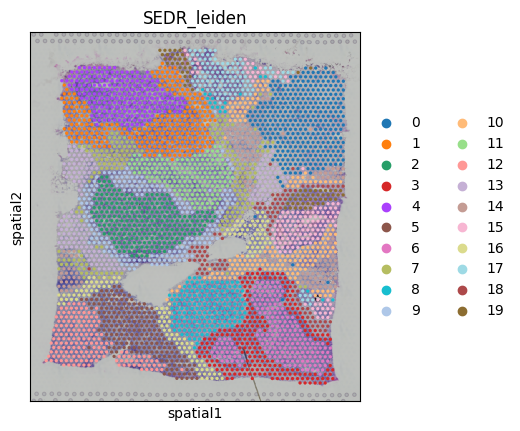

<Figure size 640x480 with 0 Axes>

In [20]:
eval_resolution = res_search_fixed_clus(adata_sedr, n_clusters)
sc.tl.leiden(adata_sedr, key_added="SEDR_leiden", resolution=eval_resolution)

sc.pl.spatial(adata_sedr, img_key="hires", color=['SEDR_leiden'], save=data_name+"_SEDR_leiden_plot")
plt.savefig(os.path.join(params.save_path, "SEDR_leiden_plot.pdf"), bbox_inches='tight', dpi=150)

df_result = pd.DataFrame(adata_sedr.obs['SEDR_leiden'], columns=['SEDR_leiden'])
df_result.to_csv(os.path.join(params.save_path, "SEDR_leiden_n_result.tsv"),
                 sep='\t', index=False)

## Visualize the train and val split

In [ ]:
from src.utils_func import train_val_split
adata_h5_train, adata_h5_val = train_val_split(adata_h5, train_frac=0.85)


In [ ]:
plot_spatial(adata_h5_val)
plot_cell2gene(adata_h5_val)